# Template notebook using AleiaModel

This notebook is a template to show basic usage of AleiaModel.

You can view AleiaModel docstrings by doing 

```python
from aleiamodel import AleiaModel
help(AleiaModel)
```

The use-case presented below sorts emails between spams and valid emails using a sklearn.svm.SVC. The input data are here given hard-coded, but it is preferable to pass a path to S3 to AleiaModel like that :

```python
model.raw_set = "notebooks/dataset/your_data.csv"
# or
model.raw_set = ("notebooks/dataset/your_data1.csv", "notebooks/dataset/your_data0.csv")
```

Note the importance of specifying "notebooks/dataset/".

We do not do it in this template so that this example can be self-contained, without outside dependancies.

Note that input data in **.csv** files will be loaded as pandas dataframes. So will data in **.parquet** files. Data in **.npy** files will be loaded as numpy arrays and data in **.json** file as dictionaries. If the file has any other extension, an attempt will be made to decode the content in a string. If it fails, the content will be unpickled.

## Imports

In [89]:
!pip install xgboost
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, coverage_error, f1_score, mean_absolute_error, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("base_IledeFrance.csv")

## <b><div style='padding:15px;background-color:#003f88;color:white;border-radius:2px;font-size:110%;text-align: center'>1  |  Data Exploration</div></b>

In [8]:
df.describe()

,Unnamed: 0,code_departement_insee,dpe_id,baie_fs,baie_u,conso_ener,estim_ges,mur_u_ext,pb_u,prc_s_vitree_ext,ph_u,s_hab,ratio_ges_conso
count,43005.0000,43005.0,4.300500e+04,24506.000000,25053.000000,43005.000000,43005.000000,24995.000000,23736.000000,22879.000000,24350.000000,42989.000000,38917.000000
mean,21502.0000,95.0,4.441258e+06,0.562375,2.638769,237.758315,34.660139,0.812803,0.877322,0.182803,0.570315,116.675801,0.152226
std,12414.6185,0.0,2.719284e+06,0.984195,0.698822,158.883999,31.342915,0.612149,0.705527,0.106426,0.731348,279.528252,0.093098
min,0.0000,95.0,3.750000e+02,0.010000,0.200000,-68.320000,0.000000,0.060000,0.070000,0.000000,0.050000,0.000000,-0.290000
25%,10751.0000,95.0,2.058362e+06,0.440000,2.200000,159.730000,11.000000,0.360000,0.350000,0.117000,0.200000,68.000000,0.050000
50%,21502.0000,95.0,4.339833e+06,0.470000,2.500000,228.020000,26.000000,0.470000,0.520000,0.156000,0.250000,93.000000,0.190000
75%,32253.0000,95.0,6.712464e+06,0.497500,2.900000,311.340000,52.000000,0.980000,2.000000,0.215000,0.430000,122.000000,0.230000
max,43004.0000,95.0,9.431150e+06,127.970000,6.200000,12880.060000,902.830000,2.860000,3.200000,0.947000,3.900000,16155.000000,0.480000


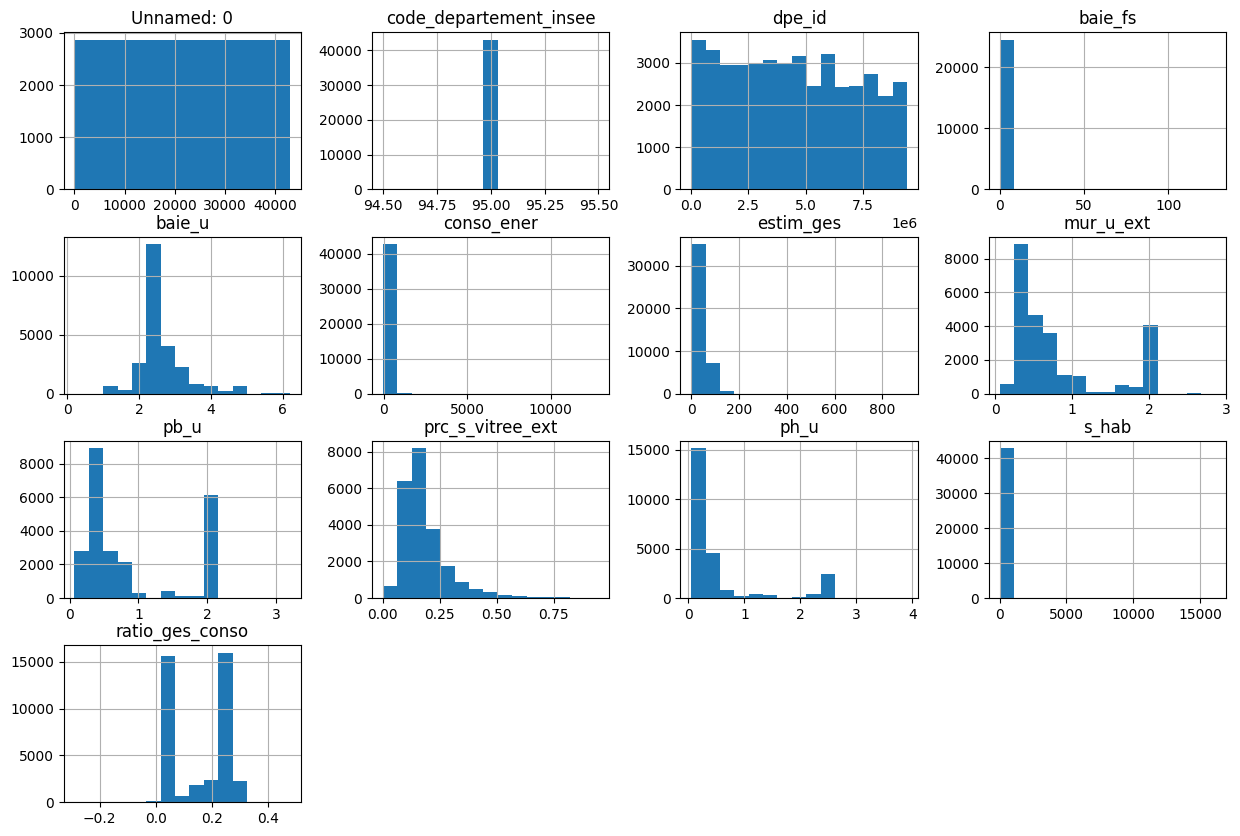

In [9]:
%matplotlib inline
df.hist(bins=15, figsize=(15, 10))
plt.show()

The dataset is unbalanced, with the 4th class being the most represented. We will need to take this into account when training our model.

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>1.1 |</span><span style='color:#003f88'> Features Descriptions</span></b>
</div>
<div style="display: flex;">
    <!-- First Column -->
    <div style="flex: 1; padding-right: 10px;">
        <!-- First column content -->
        <b>baie_fs:</b> Window solar factor.<br>
        <b>baie_mat:</b> Window frame material.<br>
        <b>baie_remplissage:</b> Type of window infill.<br>
        <b>baie_type_vitrage:</b> Type of window glazing.<br>
        <b>baie_u:</b> Thermal transmittance of the window.<br>
        <b>ch_gen_lib, ch_gen_lib_appoint, ch_gen_lib_princ:</b> Characteristics of the heating system.<br>
        <b>ch_solaire:</b> Presence of solar heating.<br>
        <b>ch_type_ener_corr:</b> Type of energy used for heating.<br>
        <b>type_ventilation:</b> Type of ventilation system, which affects air exchanges and energy use.<br>
        <b>ratio_ges_conso:</b> Ratio of greenhouse gas emissions to energy consumption.<br>
    </div>
    <!-- Second Column -->
    <div style="flex: 1; padding-right: 10px;">
        <!-- Second column content -->
        <b>ch_type_inst:</b> Type of heating installation.<br>
        <b>ecs_gen_lib, ecs_gen_lib_appoint, ecs_gen_lib_princ:</b> Characteristics of the hot water system.<br>
        <b>ecs_solaire:</b> Presence of solar hot water.<br>
        <b>ecs_type_ener:</b> Type of energy used for hot water.<br>
        <b>ecs_type_inst:</b> Type of hot water installation.<br>
        <b>enr:</b> Use of renewable energy.<br>
        <b>mur_ep_mat_ext:</b> External wall insulation thickness and material.<br>
        <b>mur_mat_ext:</b> External wall material.<br>
        <b>classe_conso_ener:</b> Energy consumption class.<br>
        <b>classe_estim_ges:</b> Estimated greenhouse gas class.<br>
        <b>conso_ener:</b> Actual energy consumption.<br>
    </div>
    <!-- Third Column -->
    <div style="flex: 1;">
        <!-- Third column content -->
        <b>mur_pos_isol_ext:</b> Position of external wall insulation.<br>
        <b>mur_u_ext:</b> Thermal transmittance of the external wall.<br>
        <b>pb_mat:</b> Floor/ceiling material.<br>
        <b>pb_pos_isol:</b> Insulation position in floors/ceilings.<br>
        <b>pb_type_adjacence:</b> Type of adjacency related to floors/ceilings.<br>
        <b>pb_u:</b> Thermal transmittance of floors/ceilings.<br>
        <b>ph_mat:</b> Roof material.<br>
        <b>ph_pos_isol:</b> Roof insulation position.<br>
        <b>ph_type_adjacence:</b> Type of adjacency related to the roof.<br>
        <b>ph_u:</b> Thermal transmittance of the roof.<br>
        <b>presence_climatisation:</b> Presence and type of air conditioning system.<br>
        <b>s_hab:</b> Habitable surface area.<br>
        <b>type_batiment:</b> Type of building, as different types may have different energy consumption p consumption.<br>
    </div>
</div>

## <b><div style='padding:15px;background-color:#003f88;color:white;border-radius:2px;font-size:110%;text-align: center'>2  |  Features Extraction</div></b>

#### We select all the feature that can be modified by the client to upgrade is energy comsumption and efficiency

In [10]:
relevant_features = [
    'baie_fs', 'baie_mat', 'baie_remplissage', 'baie_type_vitrage', 'baie_u',
    'ch_gen_lib', 'ch_gen_lib_appoint', 'ch_gen_lib_princ', 'ch_solaire', 'ch_type_ener_corr', 'ch_type_inst',
    'ecs_gen_lib', 'ecs_gen_lib_appoint', 'ecs_gen_lib_princ', 'ecs_solaire', 'ecs_type_ener', 'ecs_type_inst',
    'enr',
    'mur_ep_mat_ext', 'mur_mat_ext', 'mur_pos_isol_ext', 'mur_u_ext',
    'pb_mat', 'pb_pos_isol', 'pb_type_adjacence', 'pb_u',
    'ph_mat', 'ph_pos_isol', 'ph_type_adjacence', 'ph_u',
    'presence_climatisation',
    's_hab', 'type_batiment', 'type_ventilation',
    'ratio_ges_conso', 'classe_conso_ener', 'classe_estim_ges', 'conso_ener'
]

df_prepro = df[relevant_features]

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

label_encoders = []
df_encoded = df_prepro.copy()

for column in df_encoded.select_dtypes(include=['object', 'int', 'bool']).columns:
    label_encoder = LabelEncoder()
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    label_encoders.append((column, label_encoder))

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>2.1 |</span><span style='color:#003f88'> Correlation Matrix</span></b>
</div>

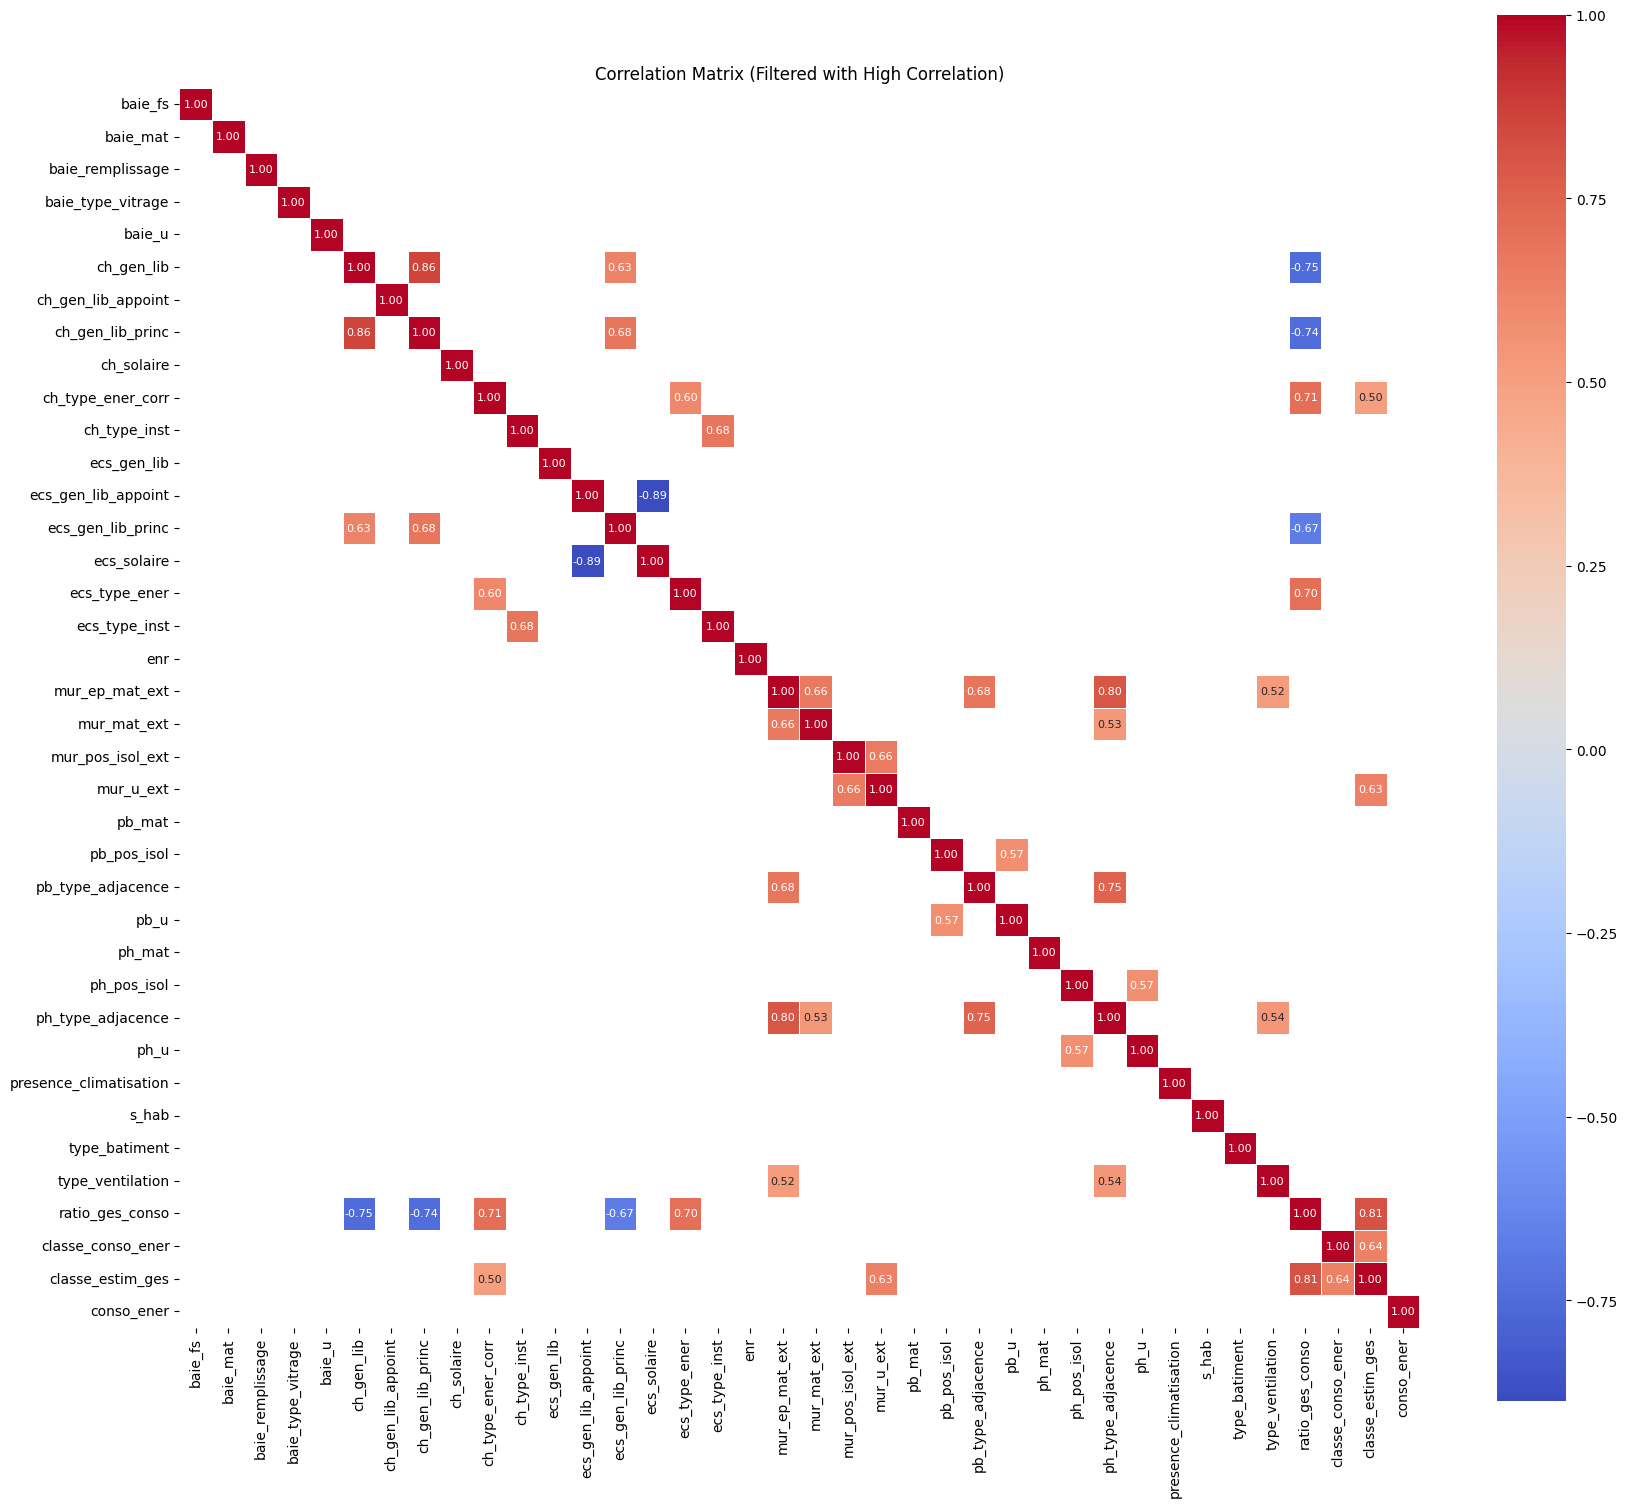

In [12]:
correlation_matrix = df_encoded.corr()
threshold = 0.5
filtered_corr = correlation_matrix.where(abs(correlation_matrix) > threshold)
plt.figure(figsize=(20, 18))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation Matrix (Filtered with High Correlation)')
plt.show()

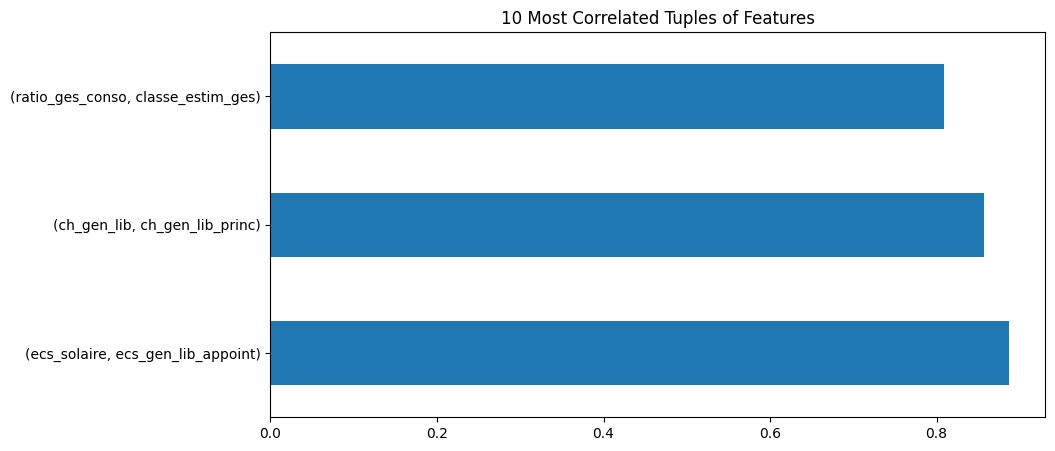

In [13]:
# plot the k most correlated tuples of features in a bar plot without the same features
k = 5
corr = df_encoded.corr().abs()
s = corr.unstack()
s = s[s != 1]
so = s.sort_values(kind="quicksort", ascending=False)
so = so[so > 0.8]
so = so[so < 1]
so = so[::2]
so = so[:k]
so.plot(kind="barh", figsize=(10, 5))
plt.title('10 Most Correlated Tuples of Features')
plt.show()

#### We can see from the correlation matrix the relevant features to be chosen. In our situation the main goal of our model will be to compute the house's energy score and then proceed to tell us which component need to be upgraded.

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>2.2 |</span><span style='color:#003f88'> Principal component analysis</span></b>
</div>

To enforce the features choice we perform a PCA to to see which component is the most influent in the note for energy comsuption. Whith that info we will be in measure to know which component need to be change first if it is not adapted to our house.

In [14]:
df_encoded = df_encoded.fillna(df_encoded.mean())

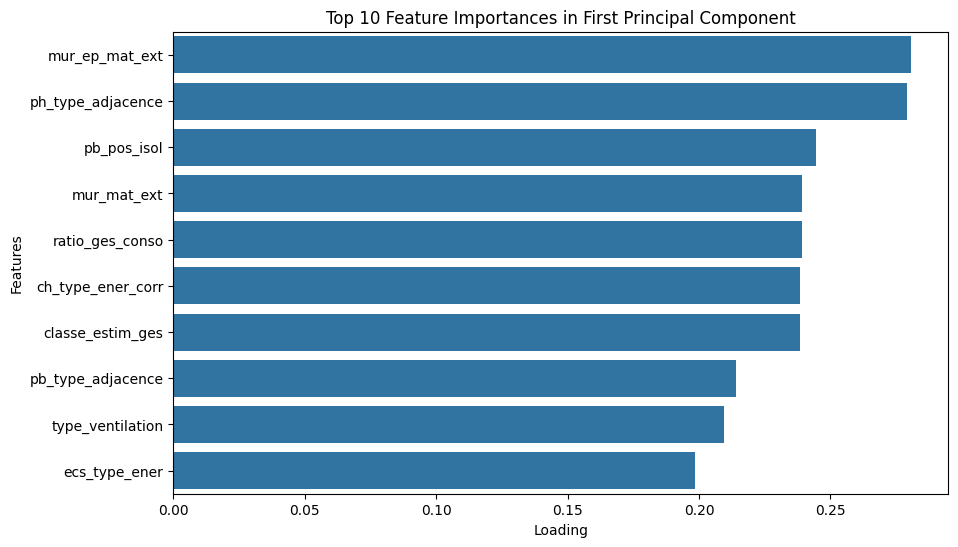

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_encoded)

pca = PCA()
principal_components = pca.fit_transform(df_standardized)

# Get the loadings for the first principal component
loadings = pca.components_[0]

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, index=df_encoded.columns, columns=['Loading'])

# Sort the loadings and select the top 10
top_10_features = loadings_df.nlargest(10, 'Loading')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_features, x='Loading', y=top_10_features.index)
plt.title('Top 10 Feature Importances in First Principal Component')
plt.xlabel('Loading')
plt.ylabel('Features')
plt.show()

## <b><div style='padding:15px;background-color:#003f88;color:white;border-radius:2px;font-size:110%;text-align: center'>3  |  Modele Creation</div></b>

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>3.1 |</span><span style='color:#003f88'> Normalize the datas</span></b>
</div>

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def normalize_float_columns(df):
    float_cols = df.select_dtypes(include=['float64', 'float32']).columns
    columns_to_scale = [col for col in float_cols if col not in ['classe_conso_ener', 'classe_estim_ges']]
    scaler = MinMaxScaler()
    df[float_cols] = scaler.fit_transform(df[columns_to_scale])
    return df

# Normalize using Standard Scaler
df_encoded = normalize_float_columns(df_encoded)
df_encoded

,baie_fs,baie_mat,baie_remplissage,baie_type_vitrage,baie_u,ch_gen_lib,ch_gen_lib_appoint,ch_gen_lib_princ,ch_solaire,ch_type_ener_corr,...,ph_type_adjacence,ph_u,presence_climatisation,s_hab,type_batiment,type_ventilation,ratio_ges_conso,classe_conso_ener,classe_estim_ges,conso_ener
0,0.004317,0,0,1,0.406462,169,26,12,0,33,...,4,0.135147,0,0.003405,3,12,0.675325,4,5,0.024150
1,0.004317,7,2,1,0.406462,405,26,19,0,24,...,4,0.135147,0,0.004024,3,15,0.415584,5,2,0.033156
2,0.004317,7,1,1,0.406462,131,26,11,0,33,...,4,0.135147,0,0.004024,0,11,0.675325,1,2,0.010673
3,0.003282,0,0,1,0.400000,216,20,19,0,11,...,2,0.033766,0,0.009285,3,5,0.441558,4,2,0.024120
4,0.003360,7,2,1,0.316667,219,26,19,0,24,...,1,0.038961,0,0.005138,3,2,0.454545,4,2,0.029140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43000,0.003673,7,0,1,0.416667,419,26,30,0,37,...,1,0.064935,0,0.003900,2,3,0.415584,3,1,0.019664
43001,0.003673,7,0,1,0.283333,419,26,30,0,37,...,1,0.064935,0,0.003466,2,10,0.415584,3,0,0.019054
43002,0.003048,7,0,1,0.383333,169,26,12,0,33,...,1,0.036364,0,0.003714,0,2,0.675325,5,6,0.033367
43003,0.003673,7,0,1,0.266667,415,3,30,0,37,...,1,0.057143,0,0.004147,2,10,0.454545,2,0,0.012544


<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>3.2 |</span><span style='color:#003f88'> Prepare the dataset</span></b>
</div>

In [17]:
to_hide = ['classe_conso_ener', 'classe_estim_ges', 'classe_estim_ges', 'conso_ener', 'ratio_ges_conso']

In [18]:
X_train_dpe, X_test_dpe, y_train_dpe, y_test_dpe = train_test_split(df_encoded.drop(columns=to_hide), df_encoded[['classe_conso_ener']],test_size = 0.2)
X_train_ges, X_test_ges, y_train_ges, y_test_ges = train_test_split(df_encoded.drop(columns=to_hide), df_encoded[['classe_estim_ges']],test_size = 0.2)

In [19]:
# get classes from y_train
classes_dpe = y_train_dpe['classe_conso_ener'].unique()
classes_dpe.sort()

classes_ges = y_train_ges['classe_estim_ges'].unique()
classes_ges.sort()

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>3.3 |</span><span style='color:#003f88'> Train the model</span></b>
</div>

In [20]:
from sklearn.utils import class_weight

class_weights_dpe = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_dpe['classe_conso_ener']
)

class_weights_ges = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_ges['classe_estim_ges']
)

In [21]:
import xgboost as xgb

model_dpe = xgb.XGBClassifier(random_state=42, device='gpu')
model_dpe.fit(X_train_dpe, y_train_dpe, sample_weight=class_weights_dpe)

model_ges = xgb.XGBClassifier(random_state=42, device='gpu')
model_ges.fit(X_train_ges, y_train_ges, sample_weight=class_weights_ges)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
# balanced accuracy
from sklearn.metrics import balanced_accuracy_score

predictions_dpe = model_dpe.predict(X_test_dpe)
accuracy_dpe = balanced_accuracy_score(y_test_dpe, predictions_dpe)
print(f"Balanced accuracy DPE: {accuracy_dpe}")

predictions_ges = model_ges.predict(X_test_ges)
accuracy_ges = balanced_accuracy_score(y_test_ges, predictions_ges)
print(f"Balanced accuracy GES: {accuracy_ges}")

Balanced accuracy DPE: 0.6009758287673992
Balanced accuracy GES: 0.6228840630356156


/home/yoku/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [17:02:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>3.4 |</span><span style='color:#003f88'> Evaluate the model</span></b>
</div>

DPE


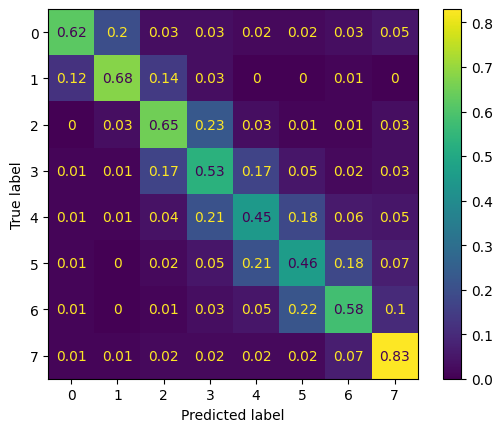

GES


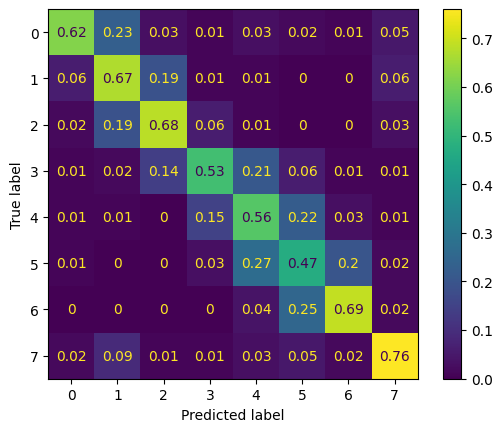

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(model, y_test, y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.round(cm_normalized, 2)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)
    disp.plot()
    plt.show()

print("DPE")
plot_cm(model_dpe, y_test_dpe, predictions_dpe)
print("GES")
plot_cm(model_ges, y_test_ges, predictions_ges) 

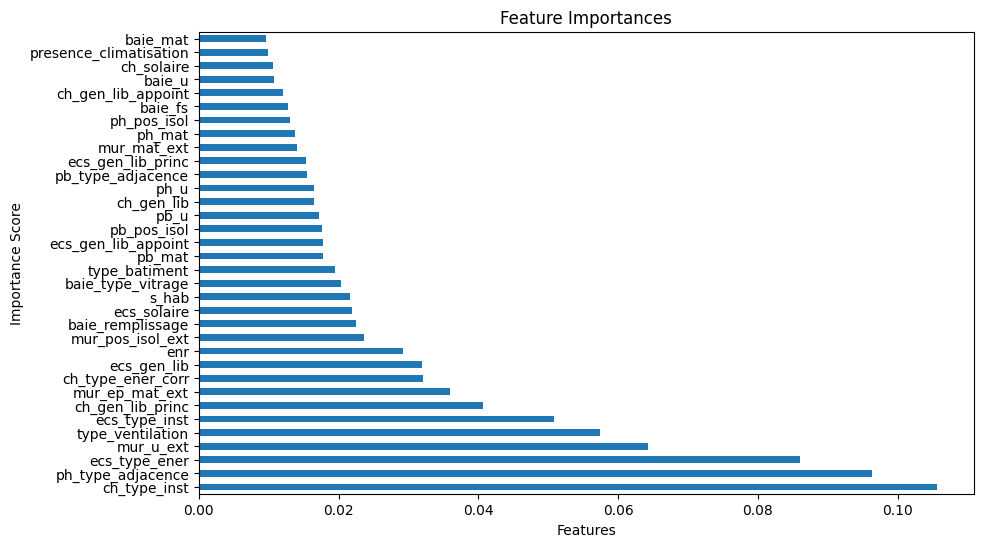

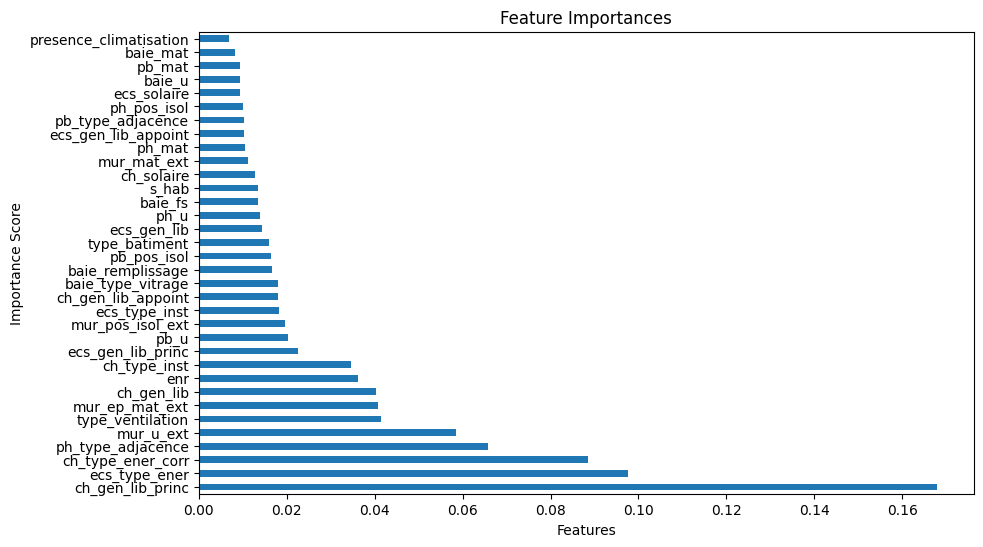

In [24]:
def fi(model, X_train):
    # Get feature importances
    feature_importances = model.feature_importances_
    
    
    # Create a pandas Series for easier visualization
    importance_series = pd.Series(feature_importances, index=X_train.columns)
    
    # Sort the features by their importance
    sorted_importance = importance_series.sort_values(ascending=False)
    
    # Plotting
    plt.figure(figsize=(10,6))
    sorted_importance.plot(kind='barh')
    plt.title('Feature Importances')
    plt.ylabel('Importance Score')
    plt.xlabel('Features')
    plt.show()

fi(model_dpe,X_train_dpe)
fi(model_ges,X_train_ges)

In [25]:
modifiable_features = [
    'baie_fs', 'baie_mat', 'baie_remplissage', 'baie_type_vitrage', 'baie_u',
    'ch_gen_lib', 'ch_gen_lib_appoint', 'ch_gen_lib_princ', 'ch_solaire', 'ch_type_ener_corr', 'ch_type_inst',
    'ecs_gen_lib', 'ecs_gen_lib_appoint', 'ecs_gen_lib_princ', 'ecs_solaire', 'ecs_type_ener', 'ecs_type_inst',
    'enr',
    'mur_ep_mat_ext', 'mur_mat_ext', 'mur_pos_isol_ext', 'mur_u_ext',
    'pb_mat', 'pb_pos_isol', 'pb_type_adjacence', 'pb_u',
    'ph_mat', 'ph_pos_isol', 'ph_type_adjacence', 'ph_u',
    'presence_climatisation',
    'type_ventilation'
]

def find_column_indexes(df, column_names):
    return {col: df.columns.get_loc(col) for col in column_names if col in df.columns}

# Get column indexes
indices_ = find_column_indexes(df_encoded, modifiable_features)
print(indices_)
column_indexes = list(indices_.values())

{'baie_fs': 0, 'baie_mat': 1, 'baie_remplissage': 2, 'baie_type_vitrage': 3, 'baie_u': 4, 'ch_gen_lib': 5, 'ch_gen_lib_appoint': 6, 'ch_gen_lib_princ': 7, 'ch_solaire': 8, 'ch_type_ener_corr': 9, 'ch_type_inst': 10, 'ecs_gen_lib': 11, 'ecs_gen_lib_appoint': 12, 'ecs_gen_lib_princ': 13, 'ecs_solaire': 14, 'ecs_type_ener': 15, 'ecs_type_inst': 16, 'enr': 17, 'mur_ep_mat_ext': 18, 'mur_mat_ext': 19, 'mur_pos_isol_ext': 20, 'mur_u_ext': 21, 'pb_mat': 22, 'pb_pos_isol': 23, 'pb_type_adjacence': 24, 'pb_u': 25, 'ph_mat': 26, 'ph_pos_isol': 27, 'ph_type_adjacence': 28, 'ph_u': 29, 'presence_climatisation': 30, 'type_ventilation': 33}


In [26]:
test_tensor_dpe = np.array(X_test_dpe.iloc[15], dtype=np.float32)
print("Predicted", model_dpe.predict([test_tensor_dpe]))
print("Groud truth", y_train_dpe["classe_conso_ener"].iloc[0])

Predicted [4]
Groud truth 3


In [ ]:
!pip install optuna

In [28]:
import optuna
import numpy as np

# Original tensor (example)
original_tensor = test_tensor_dpe
print("Original Score DPE", y_train_dpe["classe_conso_ener"].iloc[0])

# Indices of the tensor that can be modified
modifiable_indices = column_indexes
min_value, max_value = 0, 1

# Define the objective function for optimization
def objective(trial):
    # Make a copy of the original tensor
    modified_tensor = original_tensor.copy()

    diff_normalized_tensor = np.zeros_like(modified_tensor)

    # Apply modifications based on the trial suggestions
    for idx in modifiable_indices:
        col_name = df_encoded.columns[idx]
        col_type = df_encoded[col_name].dtype

        if np.issubdtype(col_type, np.floating):
            min_value, max_value = 0, 1
            sf = trial.suggest_float(f'param_{idx}', min_value, max_value)
            modified_tensor[idx] += sf
            diff_normalized_tensor[idx] = sf
        elif np.issubdtype(col_type, np.integer) or np.issubdtype(col_type, np.bool_):
            min_value, max_value = int(df_encoded[col_name].min()),int(df_encoded[col_name].max())
            si = trial.suggest_int(f'param_{idx}', min_value, max_value)
            modified_tensor[idx] += si
            diff_normalized_tensor[idx] = (int(si) - min_value) / (max_value - min_value)

    # Calculate the score using the model
    score = model_dpe.predict(modified_tensor.reshape(1, -1))[0]

    feature_importances = model_dpe.feature_importances_
    importance_score = 1 / np.sum(feature_importances * np.abs(diff_normalized_tensor))

    # # Combine the model score and importance score
    combined_score = score * importance_score

    # Since Optuna minimizes, and we want to minimize the energy consumption score, return the score directly
    return combined_score

# optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create a study object and optimize with progress bar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250, show_progress_bar=True)

# Results
print('Best score:', study.best_value)
print('Best parameters:', study.best_params)


/home/yoku/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original Score DPE 3


Best trial: 233. Best value: 5.6106: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s] 

Best score: 5.6106042633622595
Best parameters: {'param_0': 0.7642431336690101, 'param_1': 8, 'param_2': 1, 'param_3': 3, 'param_4': 0.9991515988494727, 'param_5': 304, 'param_6': 3, 'param_7': 20, 'param_8': 1, 'param_9': 3, 'param_10': 2, 'param_11': 64, 'param_12': 10, 'param_13': 16, 'param_14': 1, 'param_15': 20, 'param_16': 0, 'param_17': 6, 'param_18': 30, 'param_19': 7, 'param_20': 8, 'param_21': 0.5058502727219045, 'param_22': 7, 'param_23': 2, 'param_24': 3, 'param_25': 0.6508903541342238, 'param_26': 15, 'param_27': 5, 'param_28': 4, 'param_29': 0.9537920372986697, 'param_30': 1, 'param_33': 15}


In [39]:
# Assuming best_params is obtained from your Optuna study and df_encoded is your DataFrame
best_params = study.best_params

modified_tensor = original_tensor.copy()
change_tensor = np.zeros_like(modified_tensor)

# Apply modifications based on the trial suggestions
for idx in modifiable_indices:
    col_name = df_encoded.columns[idx]
    col_type = df_encoded[col_name].dtype

    sf = best_params[f'param_{idx}']
    modified_tensor[idx] += sf
    change_tensor[idx] = sf

# Create a DataFrame from the lists
results_df = pd.DataFrame(index=modifiable_indices, data={
    'Column': modifiable_features,
    'Old': original_tensor[modifiable_indices],
    'New': modified_tensor[modifiable_indices],
    'Change': change_tensor[modifiable_indices],
    'Feature Importance': model_dpe.feature_importances_[modifiable_indices]
})

def custom_round(x):
    if isinstance(x, (int, float)):
        if x == int(x):
            return int(x)
        else:
            return round(x, 2)
    return x

df_encoded_2 = df_encoded.copy()

# Now, to reverse it:
for column, encoder in label_encoders:
    df_encoded_2[column] = encoder.inverse_transform(df_encoded[column])

# Apply the custom round function to each element of the DataFrame
rounded_df = results_df.applymap(custom_round)

# Previous DPE
print("Previous DPE", y_train_dpe["classe_conso_ener"].iloc[0])

# New DPE
print("New DPE", model_dpe.predict([modified_tensor])[0])

# sort by feature importance
rounded_df = rounded_df.sort_values(by='Feature Importance', ascending=False)

# add a column that computes the dpe for all the changes added until that row
dpes = []
for i in range(0, len(rounded_df)):
    five_most_important_features = rounded_df.head(i)
    new_tensor = original_tensor.copy()
    for idx, row in five_most_important_features.iterrows():
        new_tensor[idx] = row['New']

    pred = model_dpe.predict([new_tensor])[0]
    dpes.append(pred)

rounded_df['DPE'] = dpes

rounded_df

/tmp/ipykernel_1128/188158241.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rounded_df = results_df.applymap(custom_round)


Previous DPE 3
New DPE 5


,Column,Old,New,Change,Feature Importance,DPE
10,ch_type_inst,1.00,2.00,1.00,0.11,3
28,ph_type_adjacence,1.00,3.00,2.00,0.10,3
15,ecs_type_ener,11.00,22.00,11.00,0.09,3
33,type_ventilation,5.00,7.00,2.00,0.06,3
21,mur_u_ext,0.13,0.42,0.29,0.06,3
16,ecs_type_inst,1.00,1.00,0.00,0.05,3
7,ch_gen_lib_princ,20.00,20.00,0.00,0.04,3
18,mur_ep_mat_ext,9.00,29.00,20.00,0.04,3
17,enr,7.00,13.00,6.00,0.03,4
9,ch_type_ener_corr,24.00,32.00,8.00,0.03,4


In [40]:
import optuna
import numpy as np


test_tensor_ges = np.array(X_test_ges.iloc[15], dtype=np.float32)

print("Predicted", model_ges.predict([test_tensor_ges]))
print("Groud truth", y_train_ges["classe_estim_ges"].iloc[0])

# Original tensor (example)
original_tensor = test_tensor_ges

# Indices of the tensor that can be modified
modifiable_indices = column_indexes
min_value, max_value = 0, 1

# Define the objective function for optimization
def objective(trial):
    # Make a copy of the original tensor
    modified_tensor = original_tensor.copy()

    diff_normalized_tensor = np.zeros_like(modified_tensor)

    # Apply modifications based on the trial suggestions
    for idx in modifiable_indices:
        col_name = df_encoded.columns[idx]
        col_type = df_encoded[col_name].dtype

        if np.issubdtype(col_type, np.floating):
            min_value, max_value = 0, 1
            sf = trial.suggest_float(f'param_{idx}', min_value, max_value)
            modified_tensor[idx] += sf
            diff_normalized_tensor[idx] = sf
        elif np.issubdtype(col_type, np.integer) or np.issubdtype(col_type, np.bool_):
            min_value, max_value = int(df_encoded[col_name].min()),int(df_encoded[col_name].max())
            si = trial.suggest_int(f'param_{idx}', min_value, max_value)
            modified_tensor[idx] += si
            diff_normalized_tensor[idx] = (int(si) - min_value) / (max_value - min_value)

    # Calculate the score using the model
    score = model_ges.predict(modified_tensor.reshape(1, -1))[0]

    feature_importances = model_dpe.feature_importances_
    importance_score = 1 / np.sum(feature_importances * np.abs(diff_normalized_tensor))

    # # Combine the model score and importance score
    combined_score = score * importance_score

    # Since Optuna minimizes, and we want to minimize the energy consumption score, return the score directly
    return combined_score

# optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create a study object and optimize with progress bar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250, show_progress_bar=True)

# Results
print('Best score:', study.best_value)
print('Best parameters:', study.best_params)


Predicted [1]
Groud truth 2


Best trial: 53. Best value: 0: 100%|██████████| 250/250 [00:47<00:00,  5.25it/s]     

Best score: 0.0
Best parameters: {'param_0': 0.16709501500337906, 'param_1': 6, 'param_2': 2, 'param_3': 5, 'param_4': 0.18003249307212743, 'param_5': 190, 'param_6': 10, 'param_7': 7, 'param_8': 0, 'param_9': 0, 'param_10': 0, 'param_11': 84, 'param_12': 6, 'param_13': 1, 'param_14': 1, 'param_15': 18, 'param_16': 2, 'param_17': 4, 'param_18': 40, 'param_19': 11, 'param_20': 9, 'param_21': 0.22542441147961587, 'param_22': 11, 'param_23': 4, 'param_24': 6, 'param_25': 0.6042973759773763, 'param_26': 5, 'param_27': 5, 'param_28': 2, 'param_29': 0.13892282173336093, 'param_30': 0, 'param_33': 5}


In [45]:
model_ges.feature_importances_[modifiable_indices].shape

(32,)

In [46]:
# Assuming best_params is obtained from your Optuna study and df_encoded is your DataFrame
best_params = study.best_params

modified_tensor = original_tensor.copy()
change_tensor = np.zeros_like(modified_tensor)

# Apply modifications based on the trial suggestions
for idx in modifiable_indices:
    col_name = df_encoded.columns[idx]
    col_type = df_encoded[col_name].dtype

    sf = best_params[f'param_{idx}']
    modified_tensor[idx] += sf
    change_tensor[idx] = sf

# Create a DataFrame from the lists
results_df = pd.DataFrame(index=modifiable_indices, data={
    'Column': modifiable_features,
    'Old': original_tensor[modifiable_indices],
    'New': modified_tensor[modifiable_indices],
    'Change': change_tensor[modifiable_indices],
    'Feature Importance': model_ges.feature_importances_[modifiable_indices]
})

def custom_round(x):
    if isinstance(x, (int, float)):
        if x == int(x):
            return int(x)
        else:
            return round(x, 2)
    return x

df_encoded_2 = df_encoded.copy()

# Now, to reverse it:
for column, encoder in label_encoders:
    df_encoded_2[column] = encoder.inverse_transform(df_encoded[column])

# Apply the custom round function to each element of the DataFrame
rounded_df = results_df.applymap(custom_round)

# Previous GES
print("Previous GES", y_train_ges["classe_estim_ges"].iloc[0])

# New GES
print("New GES", model_ges.predict([modified_tensor])[0])

# sort by feature importance
rounded_df = rounded_df.sort_values(by='Feature Importance', ascending=False)

# add a column that computes the ges for all the changes added until that row
ges = []
for i in range(0, len(rounded_df)):
    five_most_important_features = rounded_df.head(i)
    new_tensor = original_tensor.copy()
    for idx, row in five_most_important_features.iterrows():
        new_tensor[idx] = row['New']

    pred = model_ges.predict([new_tensor])[0]
    ges.append(pred)

rounded_df['GES'] = ges

rounded_df

/tmp/ipykernel_1128/1156603700.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rounded_df = results_df.applymap(custom_round)


Previous GES 2
New GES 0


,Column,Old,New,Change,Feature Importance,GES
7,ch_gen_lib_princ,20.00,27.00,7.00,0.17,1
15,ecs_type_ener,11.00,29.00,18.00,0.10,1
9,ch_type_ener_corr,24.00,24.00,0.00,0.09,2
28,ph_type_adjacence,1.00,3.00,2.00,0.07,2
21,mur_u_ext,0.13,0.35,0.23,0.06,2
33,type_ventilation,5.00,10.00,5.00,0.04,2
5,ch_gen_lib,281.00,471.00,190.00,0.04,2
18,mur_ep_mat_ext,9.00,49.00,40.00,0.04,2
17,enr,7.00,11.00,4.00,0.04,2
10,ch_type_inst,1.00,1.00,0.00,0.03,2
